<a href="https://colab.research.google.com/github/asmasw6/Diabetic-Retinopathy-Detection-/blob/main/Stack_OCT_retinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2, os
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import skimage.transform
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,BatchNormalization,Dense,GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.applications import ResNet50


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
train_dir = "/content/gdrive/MyDrive/OCT Retina/OCT2017 /train/"
print(os.listdir(train_dir))
ctg= os.listdir(train_dir)

Mounted at /content/gdrive
['CNV', 'DME', 'DRUSEN', 'NORMAL']


In [3]:

imageSize=150
#test_dir =  "../input/kermany2018/oct2017/OCT2017 /test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']


train_dir = "/content/gdrive/MyDrive/OCT Retina/OCT2017 /train/"


from tqdm import tqdm

# 8616
# 5000
# 3000

def get_data(folder, num_images_per_class=4000):
    """
    Load a fixed number of images per class from the given folder.

    Parameters:
        folder (str): Directory containing the image data.
        num_images_per_class (int): Number of images to load per class.

    Returns:
        X (numpy.ndarray): Array of image data.
        y (numpy.ndarray): Array of labels.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                continue

            # Load up to num_images_per_class images per category
            image_files = [f for f in os.listdir(os.path.join(folder, folderName)) if f.endswith(('.png', '.jpg', '.jpeg'))]
            image_files = image_files[:num_images_per_class]  # Limit to the specified number

            for image_filename in tqdm(image_files):
                img_file = cv2.imread(os.path.join(folder, folderName, image_filename))
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)

    X = np.asarray(X)
    y = np.asarray(y)
    return X, y


# Example usage
num_images_per_class = 1000
X_train, y_train = get_data(train_dir, num_images_per_class=num_images_per_class)
# X_test, y_test = get_data(test_dir, num_images_per_class=num_images_per_class)
print("finshed get data")




100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


finshed get data


In [4]:



# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("finshed Split data")


from tensorflow.keras.utils import to_categorical

# Encode labels to hot vectors
y_trainHot = to_categorical(y_train, num_classes=4)
y_testHot = to_categorical(y_test, num_classes=4)

print("Finished One hot encoding")


finshed Split data
Finished One hot encoding


0


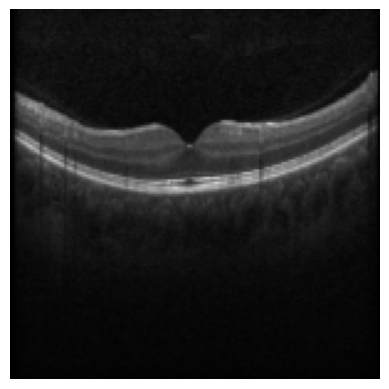

[0 1 3 ... 1 0 0]


In [ ]:

plt.imshow(X_train[0])
print(y_train[0])
plt.axis('off')  # Hide axis labels
plt.show()
print(y_train)

In [5]:

def resize_images(image_array, target_size=(imageSize, imageSize)):
    """
    Resize images to the target size.

    Parameters:
        image_array (np.array): Array of images to be resized.
        target_size (tuple): Desired size for resizing (width, height).

    Returns:
        np.array: Resized images.
    """
    resized_images = []
    for img in image_array:
        # Convert image to uint8 if necessary
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)  # If your images are normalized, scale back to 0-255

        pil_image = Image.fromarray(img)
        pil_image = pil_image.resize(target_size, Image.LANCZOS)  # Using LANCZOS (formerly ANTIALIAS)
        resized_images.append(np.array(pil_image))

    return np.array(resized_images)

# Example usage
#X_train_resized = resize_images(X_train)



def rescale_images(image_array):
    """
    Rescale pixel values to the range [0, 1].

    Parameters:
        image_array (np.array): Array of images to be rescaled.

    Returns:
        np.array: Rescaled images.
    """
    return image_array / 255.0



#-------------------------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def augment_images(image_array, target_size=(imageSize, imageSize), num_augmented_images=5):
    """
    Apply data augmentation to the images.

    Parameters:
        image_array (np.array): Array of images to be augmented with shape (num_images, height, width, channels).
        target_size (tuple): Desired size for resizing (width, height).
        num_augmented_images (int): Number of augmented images to generate per input image.

    Returns:
        np.array: Augmented images.
    """
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Ensure the input is of the shape (num_images, height, width, channels)
    if len(image_array.shape) == 4:
        # Already in the correct shape
        images_to_augment = image_array
    elif len(image_array.shape) == 3:
        # Single image, so add batch dimension
        images_to_augment = np.expand_dims(image_array, axis=0)
    else:
        raise ValueError('Input image array must be of shape (num_images, height, width, channels) or (height, width, channels)')

    augmented_images = []

    # Augment each image
    for image in images_to_augment:
        image = np.expand_dims(image, axis=0)  # Add batch dimension for ImageDataGenerator
        for _ in range(num_augmented_images):
            for batch in datagen.flow(image, batch_size=1):
                augmented_images.append(batch[0])
                break  # Break after one batch to avoid infinite loop

    return np.array(augmented_images)

# Example usage
# X_train_augmented = augment_images(X_train, num_augmented_images=5)

#-------------------------------------------------------------------------------


def preprocess_images(image_array, target_size=(imageSize, imageSize), augment=True):
    """
    Resize, rescale, and optionally augment images.

    Parameters:
        image_array (np.array): Array of images to be processed.
        target_size (tuple): Desired size for resizing (width, height).
        augment (bool): Whether to apply data augmentation.

    Returns:
        np.array: Processed images.
    """
    # Resize images
    resized_images = resize_images(image_array, target_size)
    # Rescale images
    rescaled_images = rescale_images(resized_images)

   # X_train_augmented = augment_images(X_train, num_augmented_images=5)

    return rescaled_images

# Example usage
X_train_processed = preprocess_images(X_train, augment=True)


In [ ]:
X_train_processed[0].max()

np.float64(0.807843137254902)

In [ ]:
X_train_processed.shape

(3200, 150, 150, 3)

In [6]:
from tensorflow.keras.applications import  ResNet50, InceptionV3 , DenseNet121 , EfficientNetB0, InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=13,          # Number of epochs with no improvement to stop training
    restore_best_weights=True,  # Restore model to best state after training stops
    mode='min'  # 'min' for loss, 'max' for accuracy
)

def create_base_model(model_name, input_shape=(imageSize, imageSize, 3), num_classes=4 ,  weights='imagenet'):
    if model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'resnet50': # InceptionResNetV2
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'inception_resnet_v2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError('Unknown model name')

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Adding dropout and L2 regularization
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def freeze_layers(model, num_layers_to_freeze):
    for layer in model.layers[:num_layers_to_freeze]:
        layer.trainable = False
    return model

# Example usage
DenseNet121_model = create_base_model('DenseNet121')
# Freeze the first 100 layers of DenseNet121
DenseNet121_model = freeze_layers(DenseNet121_model, num_layers_to_freeze=117)

resnet50_model = create_base_model('resnet50')
resnet50_model = freeze_layers(resnet50_model,  num_layers_to_freeze=-10)


inception_resnet_model = create_base_model('inception_resnet_v2')
inception_resnet_model = freeze_layers(inception_resnet_model, num_layers_to_freeze=590)


#inceptionv3_model = create_base_model('inceptionv3')


def train_model(model, X_train_processed, y_trainHot, X_test, y_testHot, epochs=30, batch_size=32, learning_rate=0.001, optimizer='adam'):
    # Choose optimizer
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        raise ValueError('Unknown optimizer')

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train_processed, y_trainHot,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_testHot),
        callbacks=[early_stopping]
    )

    return model, history

# Example usage with hyperparameter tuning
DenseNet121_trained, history_densenet = train_model(DenseNet121_model, X_train_processed, y_trainHot, X_test, y_testHot,  batch_size=32, learning_rate=0.0001, optimizer='adam')
print()
#resnet50_trained = train_model(resnet50_model, X_train_processed, y_trainHot, X_test, y_testHot, epochs=10, batch_size=32, learning_rate=0.0001, optimizer='rmsprop')
print()
inceptionv3_trained , history_inceptionv3 = train_model(inception_resnet_model, X_train_processed, y_trainHot, X_test, y_testHot, batch_size=32, learning_rate=0.0001, optimizer='sgd')


def extract_features(model, X):
    features = model.predict(X)
    return features

# Example usage
DenseNet121_features = extract_features(DenseNet121_trained, X_train) # accuracy: 0.2420 - loss: 1.3866 - val_accuracy: 0.2300 - val_loss: 1.3875
#resnet50_features = extract_features(resnet50_trained, X_train) #  accuracy: 0.9743 - loss: 0.0751 - val_accuracy: 0.8725 - val_loss: 0.3809
inceptionv3_features = extract_features(inceptionv3_trained, X_train)



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 144s 240ms/step - accuracy: 0.5285 - loss: 2.1048 - val_accuracy: 0.8325 - val_loss: 1.2828
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9285 - loss: 1.0135 - val_accuracy: 0.9112 - val_loss: 0.9591
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.9626 - loss: 0.7987 - val_accuracy: 0.9300 - val_loss: 0.8226
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.9823 - loss: 0.6606 - val_accuracy: 0.9312 - val_loss: 0.7968
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.9888 - loss: 0.5886 - val_accuracy: 0.9362 - val_loss: 0.7413
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9899 - loss: 0.5580 - val_accuracy: 0.9300 - val_loss: 0.7282
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accur

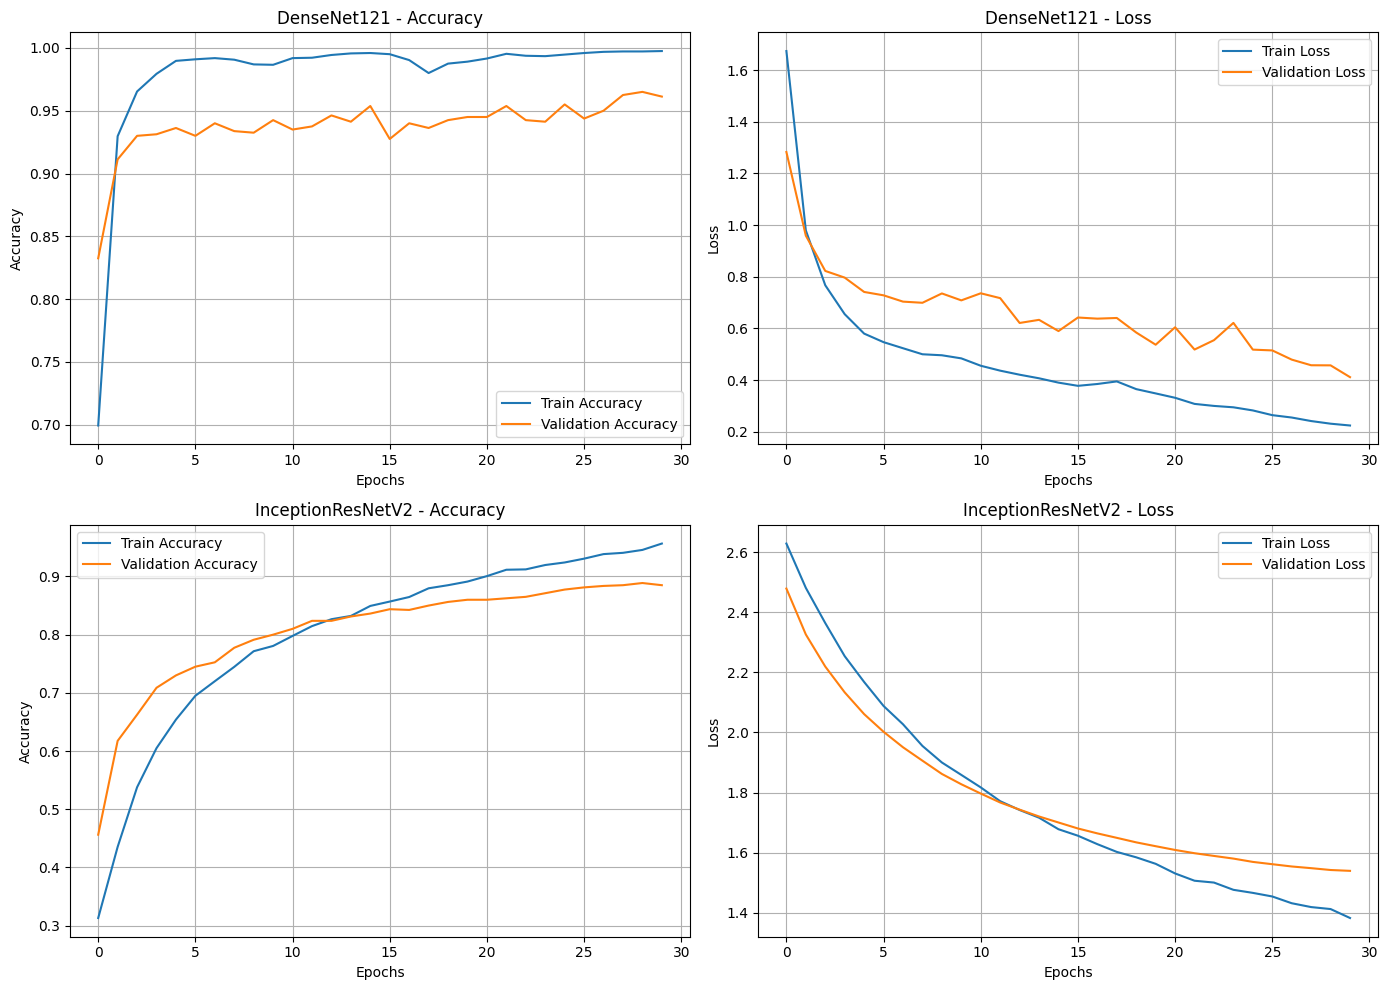

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ================= DenseNet121 =================
# Accuracy
axes[0, 0].plot(history_densenet.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('DenseNet121 - Accuracy')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history_densenet.history['loss'], label='Train Loss')
axes[0, 1].plot(history_densenet.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('DenseNet121 - Loss')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ================= InceptionResNetV2 =================
# Accuracy
axes[1, 0].plot(history_inceptionv3.history['accuracy'], label='Train Accuracy')
axes[1, 0].plot(history_inceptionv3.history['val_accuracy'], label='Validation Accuracy')
axes[1, 0].set_title('InceptionResNetV2 - Accuracy')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Loss
axes[1, 1].plot(history_inceptionv3.history['loss'], label='Train Loss')
axes[1, 1].plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
axes[1, 1].set_title('InceptionResNetV2 - Loss')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [8]:

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def stack_and_train_svm(features_list, y_train):
    # Stack features horizontally
    stacked_features = np.hstack(features_list)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(stacked_features)

    # Train SVM
    svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    svm_model.fit(scaled_features, y_train)

    return svm_model


# --------------------------------------------------------------------------------------

def stack_and_train_knn(features_list, y_train, n_neighbors=5):
    # Stack features horizontally
    stacked_features = np.hstack(features_list)

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(stacked_features)

    # Train KNN
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_model.fit(scaled_features, y_train)

    return knn_model

# Example usage
svm_model = stack_and_train_svm(
    [DenseNet121_features,
     # resnet50_features,
     inceptionv3_features],
    np.argmax(y_trainHot, axis=1)  # Convert one-hot to class labels for SVM
)



# Example usage
test_features = [extract_features(model, X_test) for model in [DenseNet121_trained,
                                                               # resnet50_trained,
                                                               inceptionv3_trained]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


In [9]:
def extract_features(model, X):
    """
    Extract features from a given model.

    Parameters:
        model: Trained model for feature extraction.
        X (np.array): Input data for feature extraction.

    Returns:
        np.array: Extracted features.
    """
    # Ensure that X is in the correct format (e.g., batch dimension if needed)
    features = model.predict(X)
    return features

def evaluate_svm(svm_model, base_models, X_test, y_testHot):
    """
    Evaluate the SVM model using features extracted from base models.

    Parameters:
        svm_model: Trained SVM model.
        base_models: List of trained base models.
        X_test (np.array): Test data.
        y_testHot (np.array): One-hot encoded test labels.

    Returns:
        float: Accuracy of the SVM model on the test data.
    """
    # Extract features from base models
    test_features = [extract_features(model, X_test) for model in base_models]
    stacked_test_features = np.hstack(test_features)

    # Standardize and predict
    predictions = svm_model.predict(stacked_test_features)
    accuracy = np.mean(predictions == np.argmax(y_testHot, axis=1))

    return accuracy


# Example usage
base_models = [DenseNet121_trained,
              # resnet50_trained,
               inceptionv3_trained]
accuracy = evaluate_svm(svm_model, base_models, X_test, y_testHot)
print(f'Test Accuracy: {accuracy}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Test Accuracy: 0.96375


/tmp/ipython-input-3914205045.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


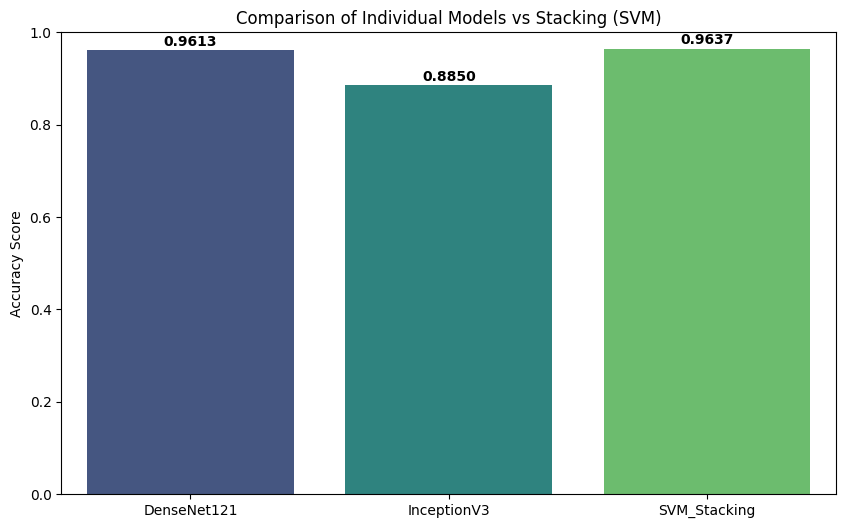

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. حساب الدقة لكل موديل منفرد (للمقارنة)
results = {}
models_names = ['DenseNet121',
                #'ResNet50',
                'InceptionV3']

for name, model in zip(models_names, base_models):
    _, acc = model.evaluate(X_test, y_testHot, verbose=0)
    results[name] = acc

# 2. إضافة دقة الـ SVM Stack
results['SVM_Stacking'] = accuracy # المتغير الذي حسبته أنت في الكود السابق

# ---------------------------------------------------------
# رسم بياني لمقارنة الدقة (Accuracy Comparison)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.ylim(0, 1.0)
plt.title('Comparison of Individual Models vs Stacking (SVM)')
plt.ylabel('Accuracy Score')
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


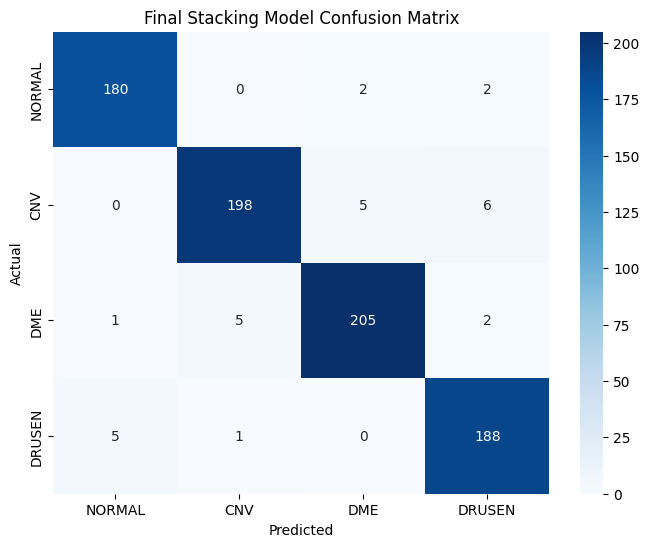


--- Detailed Classification Report ---

              precision    recall  f1-score   support

      NORMAL       0.97      0.98      0.97       184
         CNV       0.97      0.95      0.96       209
         DME       0.97      0.96      0.96       213
      DRUSEN       0.95      0.97      0.96       194

    accuracy                           0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [11]:
# الحصول على التوقعات من الـ Stacking
stacked_test_features = np.hstack([extract_features(m, X_test) for m in base_models])
y_pred = svm_model.predict(stacked_test_features)
y_true = np.argmax(y_testHot, axis=1)

# رسم مصفوفة الارتباك
cm = confusion_matrix(y_true, y_pred)
labels = ['NORMAL', 'CNV', 'DME', 'DRUSEN']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Final Stacking Model Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# طباعة تقرير مفصل
print("\n--- Detailed Classification Report ---\n")
print(classification_report(y_true, y_pred, target_names=labels))

In [12]:
# تدريب KNN Stack للمقارنة
knn_model = stack_and_train_knn(
    [DenseNet121_features,
    # resnet50_features,
     inceptionv3_features],
    np.argmax(y_trainHot, axis=1)
)

# تقييم KNN
knn_acc = evaluate_svm(knn_model, base_models, X_test, y_testHot) # نستخدم نفس الدالة

print("-" * 30)
print(f"Final SVM Stack Accuracy: {accuracy * 100:.2f}%")
print(f"Final KNN Stack Accuracy: {knn_acc * 100:.2f}%")
print("-" * 30)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step
------------------------------
Final SVM Stack Accuracy: 96.38%
Final KNN Stack Accuracy: 96.00%
------------------------------


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

def stack_and_train_logistic(features_list, y_train):
    # Stack features
    stacked_features = np.hstack(features_list)

    # Logistic Regression pipeline
    logreg_model = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            max_iter=1000,
            multi_class='auto',
            solver='lbfgs'
        )
    )

    logreg_model.fit(stacked_features, y_train)
    return logreg_model


y_train_labels = np.argmax(y_trainHot, axis=1)

svm_model = stack_and_train_svm(
    [DenseNet121_features, inceptionv3_features],
    y_train_labels
)

knn_model = stack_and_train_knn(
    [DenseNet121_features, inceptionv3_features],
    y_train_labels,
    n_neighbors=7
)

logreg_model = stack_and_train_logistic(
    [DenseNet121_features, inceptionv3_features],
    y_train_labels
)



test_features = np.hstack([
    extract_features(DenseNet121_trained, X_test),
    extract_features(inceptionv3_trained, X_test)
])

y_test_labels = np.argmax(y_testHot, axis=1)


from sklearn.metrics import accuracy_score

svm_acc = accuracy_score(y_test_labels, svm_model.predict(test_features))
knn_acc = accuracy_score(y_test_labels, knn_model.predict(test_features))
logreg_acc = accuracy_score(y_test_labels, logreg_model.predict(test_features))

print("SVM Stack Accuracy:", svm_acc)
print("KNN Stack Accuracy:", knn_acc)
print("Logistic Regression Stack Accuracy:", logreg_acc)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
SVM Stack Accuracy: 0.96375
KNN Stack Accuracy: 0.9625
Logistic Regression Stack Accuracy: 0.96375


In [14]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def stack_and_train_rf(features_list, y_train, n_estimators=300):
    # Stack features
    stacked_features = np.hstack(features_list)

    rf_model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(stacked_features, y_train)
    return rf_model
rf_model = stack_and_train_rf(
    [DenseNet121_features, inceptionv3_features],
    np.argmax(y_trainHot, axis=1)
)


rf_acc = accuracy_score(y_test_labels, rf_model.predict(test_features))

print("Random Forest Stack Accuracy:", rf_acc)


Random Forest Stack Accuracy: 0.96375
